## Demande de viz complémentaire : 
#### en réponse au commentaire du 20/05 de Guillaume Daudin (doc Etape 3, Axe 1)
"il faudrait refaire la viz [Proportion type de produits exportés par direction pour 1789] en excluant les exportations vers les ports francs? Et peut-être pour 1750 ? Et en classant par La Rochelle ?"

#### Méthode adoptée : 
- reprise du code de réalisation de la viz lors du sprint
- on enlève dans les données les flux avec pour attribut 'partner_grouping' = 'France' (ports francs)
- on réorganise le jeu de données pour que les produits les plus exportés par la DFLR apparaissent eu haut du diagramme => pour l'instant je n'y arrive pas

In [ ]:
from poitousprint import Toflit
from vega import VegaLite
import pandas as pd
from operator import itemgetter # to sort lists

toflit_client = Toflit()

In [ ]:
def prepare_flow(flow):
    f = flow.copy()
    if f['export_import'] == 'Imports' or f['export_import'] == 'import':
        f['export_import'] = 'Imports'
    if f['customs_region'] == '' or f['customs_region'] == 'National':
        f['customs_region_simpl'] = 'National'
    elif f['customs_region'] == 'La Rochelle':
        f['customs_region_simpl'] = 'La Rochelle'
    else:
        f['customs_region_simpl'] = 'Autre direction'
    f['value'] = float(f['value']) if f['value'] != '' else 0
    return f



flows_1789 = toflit_client.get_flows(year=1789, best_guess_region_prodxpart='1')
flows_1750  = toflit_client.get_flows(year=1750, best_guess_region_prodxpart='1')

total_exports_per_direction = {}
total_imports_per_direction = {}

for f in flows_1789:
    flow = prepare_flow(f)
    if flow['export_import'] == 'Imports':
        if flow['customs_region_simpl'] not in total_imports_per_direction:
            total_imports_per_direction[flow['customs_region_simpl']] = 0
        total_imports_per_direction[flow['customs_region_simpl']] += flow['value']
    else:
        if flow['customs_region_simpl'] not in total_exports_per_direction:
            total_exports_per_direction[flow['customs_region_simpl']] = 0
        total_exports_per_direction[flow['customs_region_simpl']] += flow['value']
        
def clean_flow(flow):
    f = flow.copy()
    abs_map = total_exports_per_direction if f['export_import'] == 'Exports' else total_imports_per_direction
    f['value_rel_per_direction'] = f['value'] / abs_map[f['customs_region_simpl']]
    return f       

In [ ]:
flows_1789 = [clean_flow(prepare_flow(f)) for f in flows_1789]
flows_1750 = [clean_flow(prepare_flow(f)) for f in flows_1750]

In [ ]:
def aggregate_flows_by_product(flows):
    flows_aggregated_by_product = {}
    # je veux construire un dict par produit, en distinguant LR / pas LR
    
    for flow in flows:
        if flow['product_revolutionempire'] not in flows_aggregated_by_product:
            flows_aggregated_by_product[flow['product_revolutionempire']] = {
                'product':flow['product_revolutionempire'],
                'exports_la_rochelle': 0,
                'exports_autres_directions':0,
                }
    # à la fin pour chaque produit je sommerais le total export pour calculer du relatif  
        if flow['partner_grouping'] != 'France':
            if flow['customs_region_simpl'] == 'La Rochelle':
                # print("found")
                flows_aggregated_by_product[flow['product_revolutionempire']]['exports_la_rochelle'] += flow['value']
            else:
                flows_aggregated_by_product[flow['product_revolutionempire']]['exports_autres_directions'] += flow['value']

    return flows_aggregated_by_product

In [ ]:
product_exports_values_per_direction_1789 = aggregate_flows_by_product(flows_1789)

total_exports_la_rochelle_1789 = 0
total_exports_autres_directions_1789 = 0

for product, values in product_exports_values_per_direction_1789.items():
    total_exports_la_rochelle_1789 += values['exports_la_rochelle']
    total_exports_autres_directions_1789 += values['exports_autres_directions']
    
for product, values in product_exports_values_per_direction_1789.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1789
    values['exports_rel_autres_directions'] = values['exports_autres_directions'] / total_exports_autres_directions_1789

In [ ]:
sorted_product_exports_values_per_direction_1789 = sorted(product_exports_values_per_direction_1789.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)
# print(sorted_product_exports_values_per_direction_1789)

In [ ]:
final_vega_data_1789 = []

i = 0
for values in sorted_product_exports_values_per_direction_1789:
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "direction_des_fermes" : 'La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "direction_des_fermes" : 'Autre direction',
        "value_rel_per_direction" : values['exports_rel_autres_directions'],
        "order":i
    })
    
    i += 1
    
# print(final_vega_data_1789)

In [ ]:
product_exports_values_per_direction_1750 = aggregate_flows_by_product(flows_1750)

total_exports_la_rochelle_1750 = 0
total_exports_autres_directions_1750 = 0

for product, values in product_exports_values_per_direction_1750.items():
    total_exports_la_rochelle_1750 += values['exports_la_rochelle']
    total_exports_autres_directions_1750 += values['exports_autres_directions']
    
for product, values in product_exports_values_per_direction_1750.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1750
    values['exports_rel_autres_directions'] = values['exports_autres_directions'] / total_exports_autres_directions_1750

In [ ]:
sorted_product_exports_values_per_direction_1750 = sorted(product_exports_values_per_direction_1750.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)
# print(sorted_product_exports_values_per_direction_1750)

In [ ]:
final_vega_data_1750 = []

i = 0
for values in sorted_product_exports_values_per_direction_1750:
    
    final_vega_data_1750.append({
        "product" : values['product'],
        "direction_des_fermes" : 'La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1750.append({
        "product" : values['product'],
        "direction_des_fermes" : 'Autre direction',
        "value_rel_per_direction" : values['exports_rel_autres_directions'],
        "order":i
    })
    
    i += 1
    
# print(final_vega_data_1750)

### V2 de la viz : grouped-bar chart

#### (Exemple Vega-lite original : accessible à https://vega.github.io/vega-lite/examples/bar_grouped.html)

In [ ]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Proportion des types de produits exportés par direction pour 1750",
  "height": {"step": 50},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", "type": "nominal", "spacing": 10, "sort":{"field" : "order"}
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part de la somme des valeurs par rapport au total par direction",
      "axis": {"orient":"top"},
      "type":"quantitative"
    },
    "y": {
      "field": "direction_des_fermes",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "direction_des_fermes",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1750))

In [ ]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Proportion des types de produits exportés par direction pour 1789",
  "height": {"step": 50},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", "type": "nominal", "spacing": 10, "sort":{"field" : "order"}
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part de la somme des valeurs par rapport au total par direction",
      "axis": {"orient": "top"},
      "type":"quantitative"
    },
    "y": {
      "field": "direction_des_fermes",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "direction_des_fermes",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1789))

### Anciennes visualisations :

In [ ]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Proportion des types de produits exportés par direction pour 1789",
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "customs_region_simpl",
            "type": "nominal", 
            "title": "Direction",
            "sort": "-size"
        },
        "y": {
            "type": "nominal",
            "field": "product_revolutionempire",
            "sort": "-size"
        },
        "color": {
            "field": "customs_region_simpl",
            "type": "nominal", 
            "title": "Direction",
            "sort": "-size"
        },
        "size": {
            "type": "quantitative",
            "field": "value_rel_per_direction",
            "title": "Part de la somme des valeurs par rapport au total par direction",
            "aggregate": "sum"
        }
    }
}, pd.DataFrame([clean_flow(f) for f in flows_1789 if (f['export_import'] == 'Exports' and f['partner_grouping'] != 'France')]))

In [ ]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Proportion des types de produits exportés par direction pour 1750",
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "customs_region_simpl",
            "type": "nominal", 
            "title": "Direction",
            "sort": "-size"
        },
        "y": {
            "type": "nominal",
            "field": "product_revolutionempire",
            "sort": "-size"
        },
        "color": {
            "field": "customs_region_simpl",
            "type": "nominal", 
            "title": "Direction",
            "sort": ["Étoffes de laine", "Toiles de chanvre et de lin", "Sucre", "Vins de Bordeaux","Étoffes de soie", "Café", "Mercerie", "Indigo", "Ouvrages divers et mélangés", "Étoffes diverses", "Dorure", "Toiles diverses", "Toiles de coton", "Dentelle", "Soieries diverses", "Eaux-de-vie et liqueurs"]
        },
        "size": {
            "type": "quantitative",
            "field": "value_rel_per_direction",
            "title": "Part de la somme des valeurs par rapport au total par direction",
            "aggregate": "sum"
        }
    }
}, pd.DataFrame([clean_flow(f) for f in flows_1750 if (f['export_import'] == 'Exports' and f['partner_grouping'] != 'France')]))

In [ ]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Proportion des types de produits exportés par direction pour 1750",
    "mark": "circle",
    "encoding": {
        "column": {
            "field": "customs_region_simpl"
        },
        "x": {
            "field": "partner_grouping",
            "type": "nominal", 
            "title": "Partenaire de commerce",
            "sort": "-size"
        },
        "y": {
            "type": "nominal",
            "field": "product_revolutionempire",
            "sort": "-size"
        },
        "color": {
            "field": "customs_region_simpl",
            "title": "Comparaison entre la Rochelle et les autres directions",
            "type": "nominal", 
            "title": "Direction",
            "sort": "-size"
        },
        "size": {
            "type": "quantitative",
            "field": "value_rel_per_direction",
            "aggregate": "sum"
        }
    }
}, pd.DataFrame([clean_flow(f) for f in flows_1750 if (f['export_import'] == 'Exports' and f['partner_grouping'] != 'France')]))

In [9]:
from poitousprint import Toflit
from vega import VegaLite
import pandas as pd
from operator import itemgetter # to sort lists

toflit_client = Toflit()

def prepare_flow(flow):
    f = flow.copy()
    if f['export_import'] == 'Imports' or f['export_import'] == 'import':
        f['export_import'] = 'Imports'
    elif f['customs_region'] == '' or f['customs_region'] == 'National':
        f['customs_region_simpl'] = 'National'
    if f['customs_region'] == 'La Rochelle':
        f['customs_region_simpl'] = 'La Rochelle'
    else:
        f['customs_region_simpl'] = 'Autre direction'
    f['value'] = float(f['value']) if f['value'] != '' else 0
    return f

def clean_flow(flow):
    f = flow.copy()
    abs_map = total_exports_per_direction if f['export_import'] == 'Exports' else total_imports_per_direction
    f['value_rel_per_direction'] = f['value'] / abs_map[f['customs_region_simpl']]
    return f   

def aggregate_flows_by_product(flows):
    flows_aggregated_by_product = {}
    # je veux construire un dict par produit, en distinguant LR / pas LR
    
    for flow in flows:
        if flow['product_revolutionempire'] not in flows_aggregated_by_product:
            flows_aggregated_by_product[flow['product_revolutionempire']] = {
                'product':flow['product_revolutionempire'],
                'exports_la_rochelle': 0,
                'exports_toute_france':0,
                }
    # à la fin pour chaque produit je sommerais le total export pour calculer du relatif  
        if flow['partner_grouping'] != 'France':
            if flow['customs_region_simpl'] == 'La Rochelle':
                flows_aggregated_by_product[flow['product_revolutionempire']]['exports_la_rochelle'] += flow['value']
            flows_aggregated_by_product[flow['product_revolutionempire']]['exports_toute_france'] += flow['value']

    return flows_aggregated_by_product

total_exports_per_direction = {}
total_imports_per_direction = {}

# flows_1750  = toflit_client.get_flows(year=1750, best_guess_region_prodxpart='1')
flows_1789 = toflit_client.get_flows(year=1789, best_guess_region_prodxpart='1')

for f in flows_1789:
    flow = prepare_flow(f)
    if flow['export_import'] == 'Imports':
        if flow['customs_region_simpl'] not in total_imports_per_direction:
            total_imports_per_direction[flow['customs_region_simpl']] = 0
        total_imports_per_direction[flow['customs_region_simpl']] += flow['value']
    else:
        if flow['customs_region_simpl'] not in total_exports_per_direction:
            total_exports_per_direction[flow['customs_region_simpl']] = 0
        total_exports_per_direction[flow['customs_region_simpl']] += flow['value']
        
# flows_1750 = [clean_flow(prepare_flow(f)) for f in flows_1750]
flows_1789 = [clean_flow(prepare_flow(f)) for f in flows_1789]


# aggregation des flux par produit
product_exports_values_per_direction_1789 = aggregate_flows_by_product(flows_1789)


# calcul de la part de chaque produit dans les exports totaux
total_exports_la_rochelle_1789 = 0
total_exports_toute_france_1789 = 0

for product, values in product_exports_values_per_direction_1789.items():
    total_exports_la_rochelle_1789 += values['exports_la_rochelle']
    total_exports_toute_france_1789 += values['exports_toute_france']

for product, values in product_exports_values_per_direction_1789.items():
    values['exports_rel_la_rochelle'] = values['exports_la_rochelle'] / total_exports_la_rochelle_1789
    values['exports_rel_toute_france'] = values['exports_toute_france'] / total_exports_toute_france_1789

# ordonner en mettant en premier les produits les plus importants pour La Rochelle
sorted_product_exports_values_per_direction_1789 = sorted(product_exports_values_per_direction_1789.values(), key=itemgetter('exports_rel_la_rochelle'), reverse=True)

# reformatter les données sous la forme d'un ensemble de dicts : un dict par produit pour La Rochelle et un dict par produit pour l'ensemble de la France
final_vega_data_1789 = []
i = 0
for values in sorted_product_exports_values_per_direction_1789:
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "direction_des_fermes" : 'La Rochelle',
        "value_rel_per_direction" : values['exports_rel_la_rochelle'],
        "order":i
    })
    
    final_vega_data_1789.append({
        "product" : values['product'],
        "direction_des_fermes" : "Total France",
        "value_rel_per_direction" : values['exports_rel_toute_france'],
        "order":i
    })
    
    i += 1

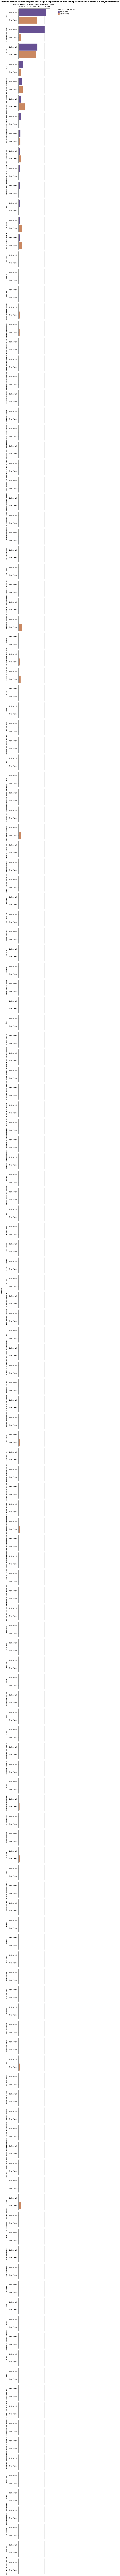

In [11]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Produits dont les valeurs d'exports sont les plus importantes en 1789 : comparaison de La Rochelle à la moyenne française",
  "height": {"step": 50},
  "mark": "bar",
  "encoding": {
    "row": {
      "field": "product", "type": "nominal", "spacing": 10, "sort":{"field" : "order"}
    },
    "x": {
      "aggregate": "sum", "field": "value_rel_per_direction",
      "title": "Part du produit dans le total des exports (en valeur)",
      "axis": {"orient": "top"},
      "type":"quantitative"
    },
    "y": {
      "field": "direction_des_fermes",
      "axis": {"title": ""},
      "type":"nominal",
      "sort":{"order":"descending"}
    },
    "color": {
      "field": "direction_des_fermes",
      "scale": {"range": ["#675193", "#ca8861"]}
    }
  },
  "config": {
    "view": {"stroke": "transparent"},
    "axis": {"domainWidth": 1}
  }
}, pd.DataFrame(final_vega_data_1789))